In [1]:
import os
import glob
import gc
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib.image import imread
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# With glob method

kirmizi_path = glob.glob('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/*')
siirt_path = glob.glob('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/*')

train_k, test_k = train_test_split(kirmizi_path, test_size=0.2, random_state=42)
train_s, test_s = train_test_split(siirt_path, test_size=0.2, random_state=42)

# move to folder

def move_file(file_path, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for file in file_path:
        shutil.copy(file, destination_folder)

move_file(train_k, '/kaggle/working/train/kirmizi')
move_file(train_s, '/kaggle/working/train/siirt')
move_file(test_k, '/kaggle/working/test/kirmizi')
move_file(test_s, '/kaggle/working/test/siirt')

train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'

The Image size of Kirmizi: (600, 600, 3)
The Image size of Siirt: (600, 600, 3)


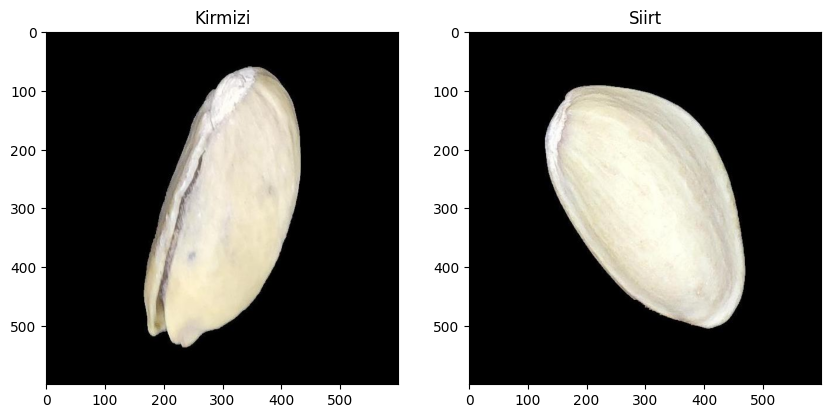

In [3]:
# what's the difference between Kirmizi and siirt
print(f"The Image size of Kirmizi: {imread(train_k[0]).shape}")
print(f"The Image size of Siirt: {imread(train_s[0]).shape}")
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(imread(train_k[0]))
ax[0].set_title('Kirmizi')
ax[1].imshow(imread(train_s[0]))
ax[1].set_title('Siirt');

The image numbers of Kirmizi: 1232
The image numbers of Siirt: 916


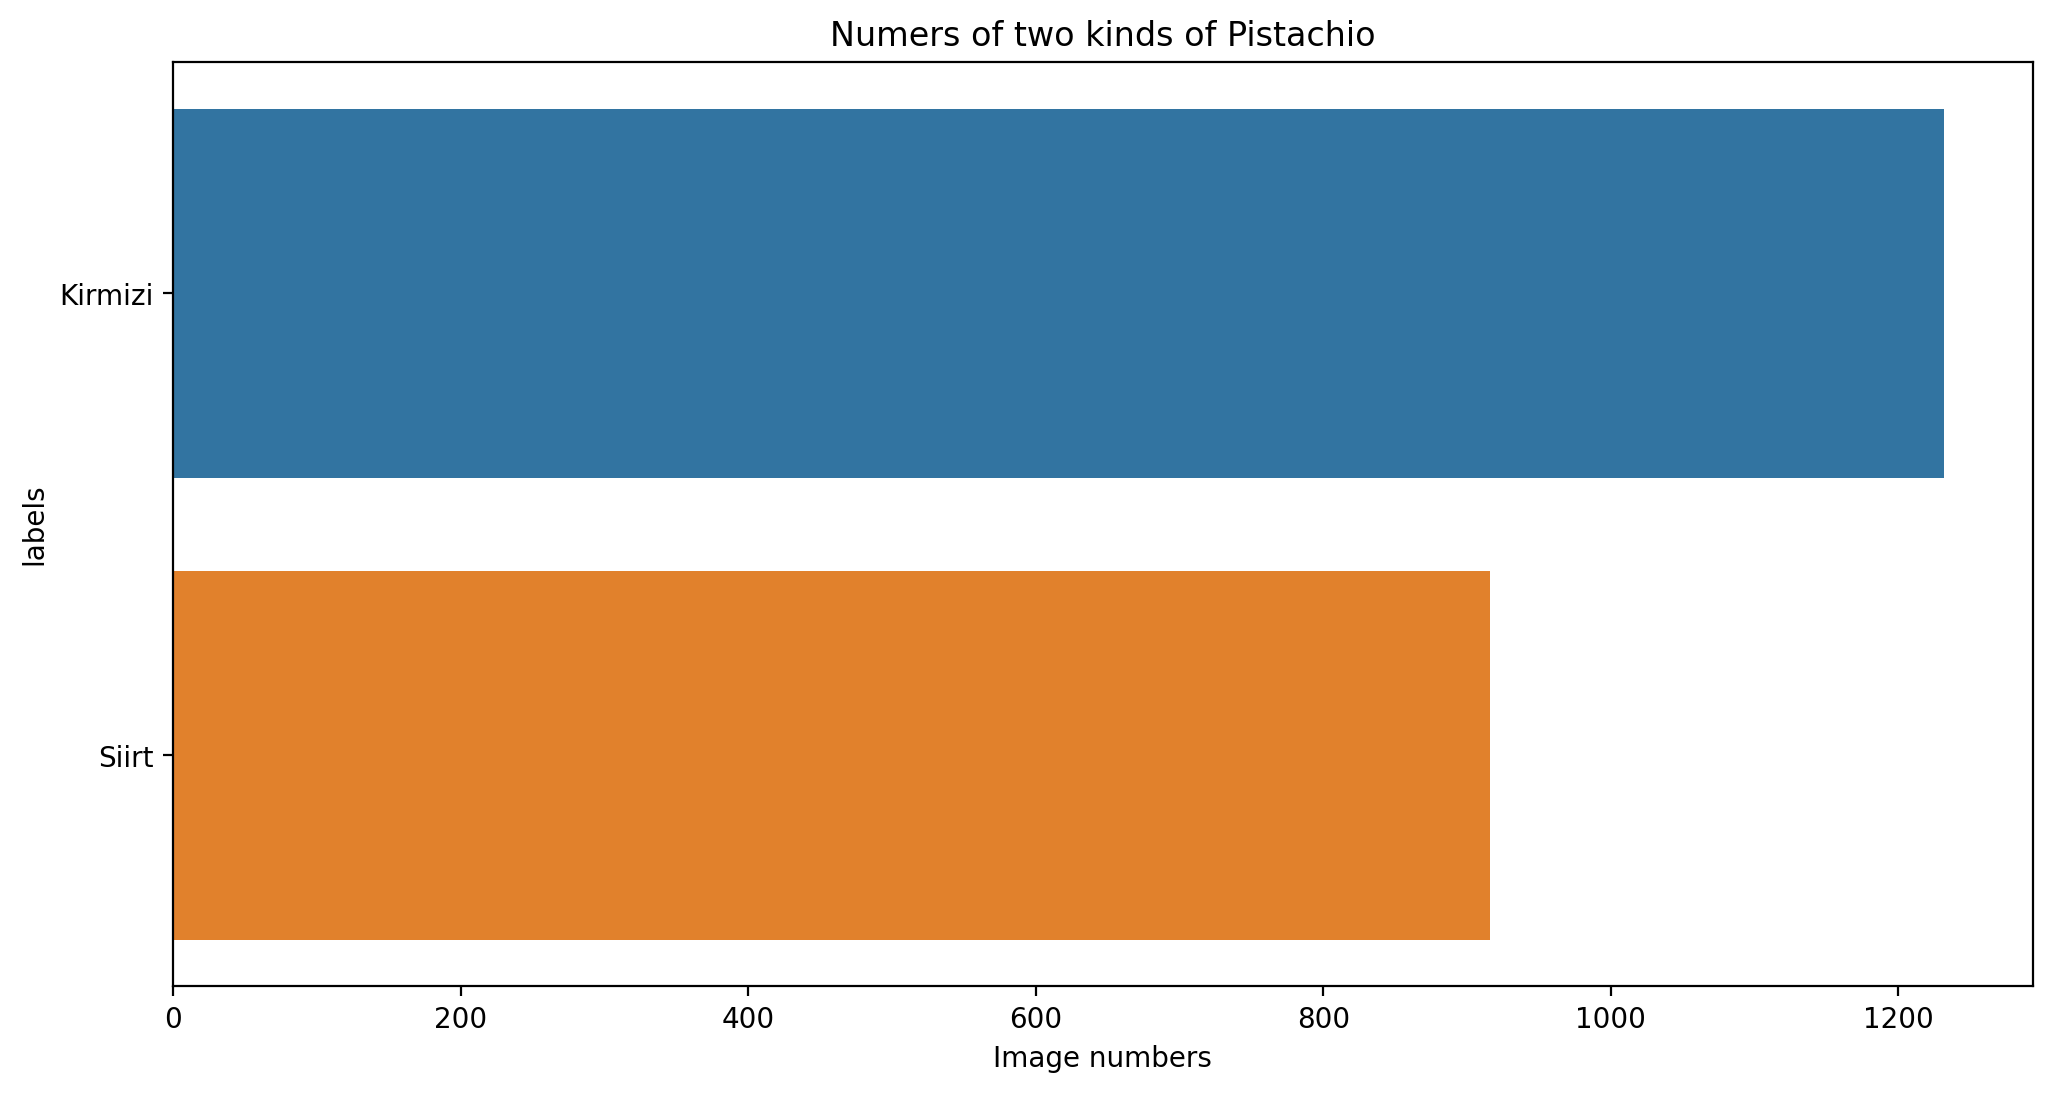

In [4]:
# the distribution of two kinds of Pistachio
num_k = len(os.listdir('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio'))
num_s = len(os.listdir('/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio'))
df = pd.DataFrame({'labels':['Kirmizi', 'Siirt'],
                  'Image numbers':[num_k, num_s]})
print(f"The image numbers of Kirmizi: {num_k}")
print(f"The image numbers of Siirt: {num_s}")
plt.figure(figsize=(12,6), dpi=200)
sns.barplot(df, y='labels', x='Image numbers')
plt.title('Numers of two kinds of Pistachio');

 <!-- headings -->
 <a id="item4"></a>
##  Image Generator  


In [5]:
# Initialize ImageDataGenerator
image_gen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.2, 
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_shape = (224, 224, 3)

**Alright, now we can apply random transformations to the entire dataset.**

In [6]:
# apply image generator to train and test dataset
batch_size = 64
train_gen = image_gen.flow_from_directory(
    train_path, target_size=image_shape[:2], color_mode='rgb',
    batch_size=batch_size, class_mode='binary'
)
test_gen = image_gen.flow_from_directory(
    test_path, target_size=image_shape[:2], color_mode='rgb',
    batch_size=batch_size, class_mode='binary'
)
print(train_gen.class_indices)
print(test_gen.class_indices)

Found 1717 images belonging to 2 classes.
Found 431 images belonging to 2 classes.
{'kirmizi': 0, 'siirt': 1}
{'kirmizi': 0, 'siirt': 1}


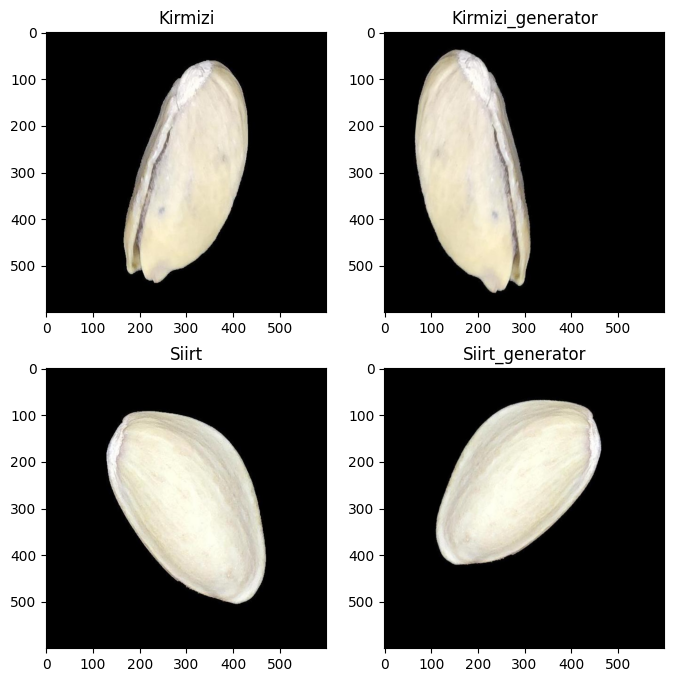

In [7]:
# how it looks like for image generator
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(imread(train_k[0]))
ax[0,0].set_title('Kirmizi')
ax[1,0].imshow(imread(train_s[0]))
ax[1,0].set_title('Siirt')
ax[0,1].imshow(image_gen.random_transform(imread(train_k[0])))
ax[0,1].set_title('Kirmizi_generator')
ax[1,1].imshow(image_gen.random_transform(imread(train_s[0])))
ax[1,1].set_title('Siirt_generator');

 <!-- headings -->
 <a id="item5"></a>
 ## CNN Model


In [8]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=early_stop)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 256)               4

<Axes: >

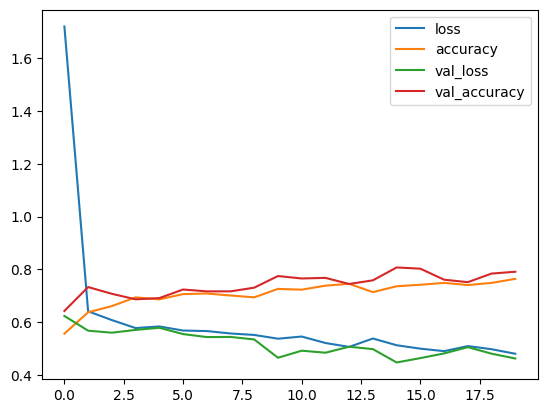

In [9]:
pd.DataFrame(model.history.history).plot()

**It seems that our self-built model is not performing very well, with an accuracy of only 0.68**

In [10]:
loss, accuracy = model.evaluate(test_gen)

7/7 [==============================] - 6s 885ms/step - loss: 0.4307 - accuracy: 0.8190


 <!-- headings -->
 <a id="item6"></a>
 ## Create VGG16 Model


In [11]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_shape))
vgg16.trainable = False
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
# create layer
x = vgg16.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
# create model
model = Model(inputs=vgg16.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=early_stop)


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

<Axes: >

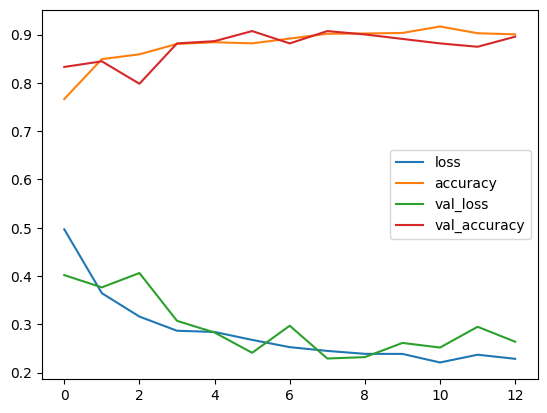

In [12]:
pd.DataFrame(model.history.history).plot()

In [13]:
loss, accuracy = model.evaluate(test_gen)

7/7 [==============================] - 6s 867ms/step - loss: 0.2703 - accuracy: 0.9026


 <!-- headings -->
 <a id="item7"></a>
 ## Create MobileNet Model


In [14]:
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
mobile_net.trainable = False
# create layer
x = mobile_net.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=mobile_net.input, outputs=output)
optimizer = Adam(learning_rate=0.00003)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model_check = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[early_stop, model_check])

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
27/27 [==============================] - 37s 1s/step - loss: 0.3409 - accuracy: 0.8439 - val_loss: 0.2523 - val_accuracy: 0.9142
Epoch 2/20
27/27 [==============================] - 31s 1s/step - loss: 0.1882 - accuracy: 0.9260 - val_loss: 0.2181 - val_accuracy: 0.9211
Epoch 3/20
27/27 [==============================] - 31s 1s/step - loss: 0.1524 - accuracy: 0.9388 - val_loss: 0.1382 - val_accuracy: 0.9466
Epoch 4/20
27/27 [==============================] - 30s 1s/step - loss: 0.1396 - accuracy: 0.9487 - val_loss: 0.1857 - val_accuracy: 0.9234
Epoch 5/20
27/27 [==============================] - 30s 1s/step - loss: 0.1208 - accuracy: 0.9563 - val_loss: 0.1289 - val_accuracy: 0.9466
Epoch 6/20
27/27 [==============================] - 31s 1s/step - loss: 0.1011 - accuracy: 0.9604 - val_loss: 0.1158 - val_accuracy: 0.9536
Epoch 7/20
27/27 [==============================] - 32s 1s/step - loss: 0.0942 - accuracy: 0.9656

<Axes: >

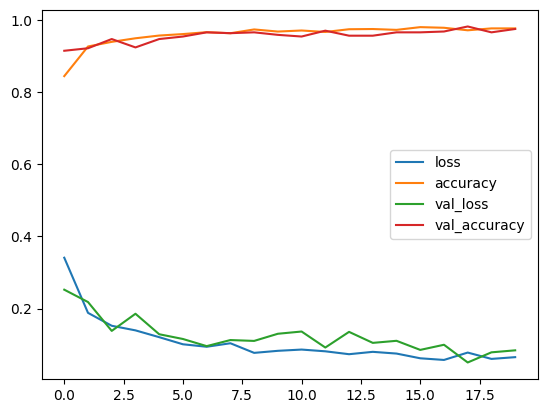

In [15]:
pd.DataFrame(model.history.history).plot()

In [16]:
loss, accuracy = model.evaluate(test_gen)

7/7 [==============================] - 6s 853ms/step - loss: 0.0985 - accuracy: 0.9606


 <!-- headings -->
 <a id="item8"></a>
 ##  Create EfficientNet Model  


In [17]:
enetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=image_shape)
enetb0.trainable = False

# for layer in enetb0.layers[:-15]:
#     layer.trainable = False
x = enetb0.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=enetb0.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[early_stop])

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/20


2023-10-24 11:19:47.572107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 40s 1s/step - loss: 0.7760 - accuracy: 0.4910 - val_loss: 0.9769 - val_accuracy: 0.5731
Epoch 2/20
27/27 [==============================] - 31s 1s/step - loss: 0.7361 - accuracy: 0.5108 - val_loss: 0.6980 - val_accuracy: 0.5731
Epoch 3/20
27/27 [==============================] - 30s 1s/step - loss: 0.7269 - accuracy: 0.5143 - val_loss: 1.4224 - val_accuracy: 0.4269
Epoch 4/20
27/27 [==============================] - 31s 1s/step - loss: 0.7328 - accuracy: 0.4939 - val_loss: 0.7789 - val_accuracy: 0.5731
Epoch 5/20
27/27 [==============================] - 30s 1s/step - loss: 0.7286 - accuracy: 0.5242 - val_loss: 1.8636 - val_accuracy: 0.5731
Epoch 6/20
27/27 [==============================] - 30s 1s/step - loss: 0.7158 - accuracy: 0.5183 - val_loss: 0.8940 - val_accuracy: 0.5731
Epoch 7/20
27/27 [==============================] - 30s 1s/step - loss: 0.7125 - accuracy: 0.5347 - val_loss: 0.6852 - val_accuracy: 0.6705
Epoch 8/20
27/27 [=============

In [18]:
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 20.2 MB/s eta 0:00:00


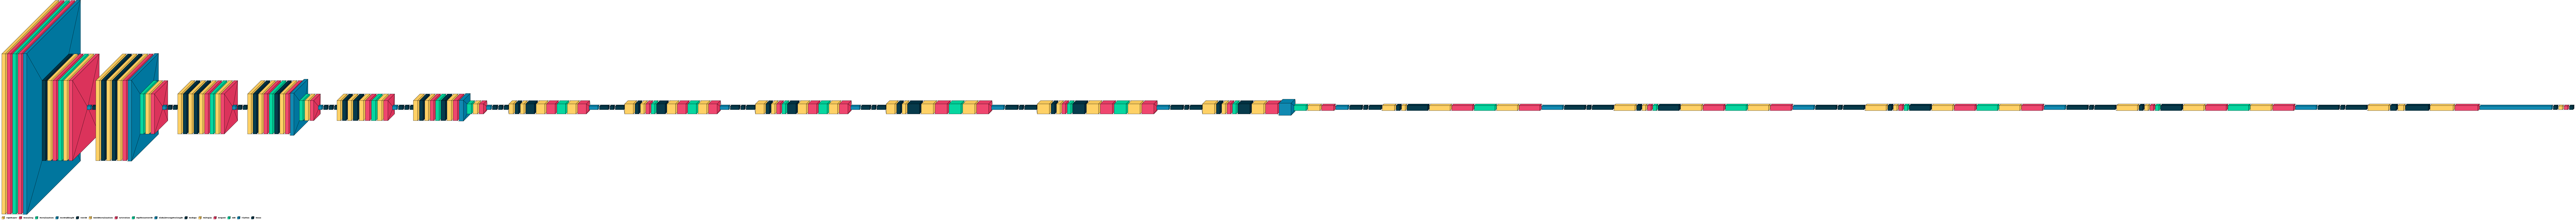

In [19]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

 <!-- headings -->
 <a id="item9"></a>
 ## Predict and Evaluate Model with Data Visualization


In [20]:
# predict the model
y_pred = model.predict(test_gen)

7/7 [==============================] - 7s 847ms/step


1/1 [==============================] - 0s 24ms/step


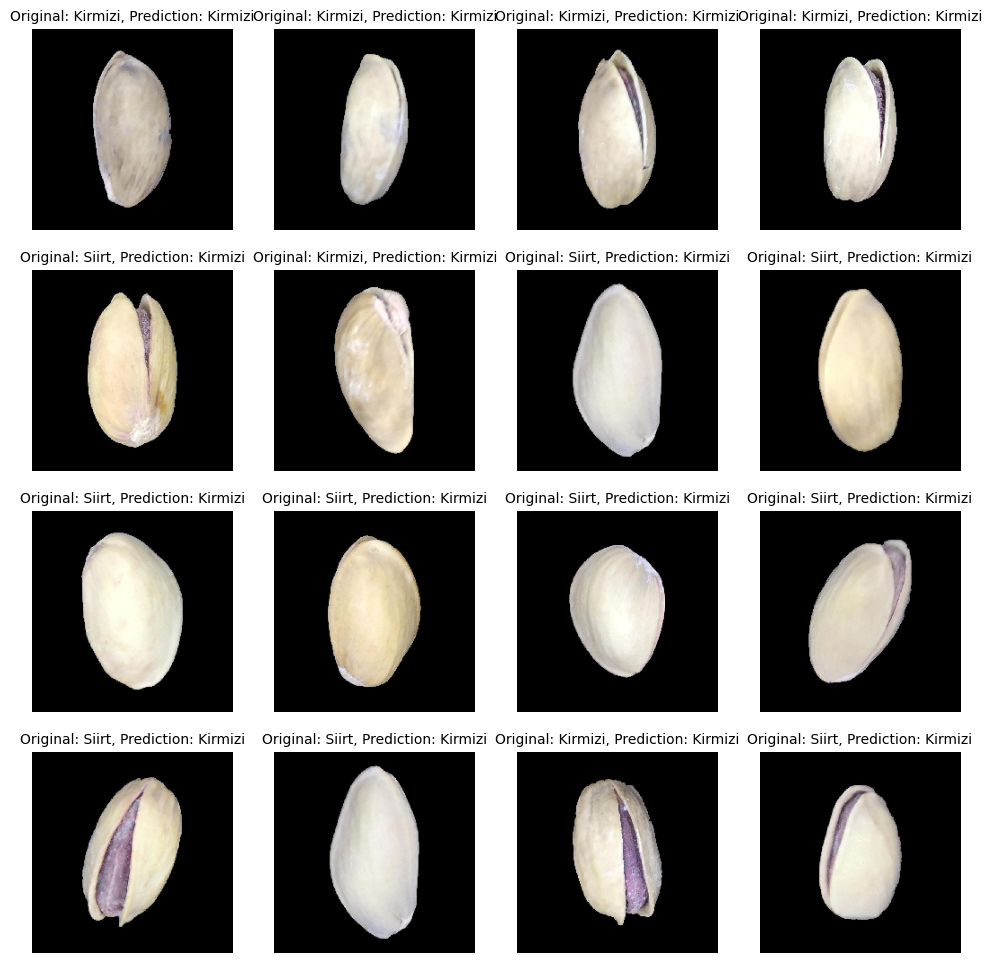

In [21]:
# combine the image of two folder
test_Kirmizi_folder = "/kaggle/working/test/kirmizi"
test_Siirt_folder = "/kaggle/working/test/siirt"
Kirmizi_files = [os.path.join(test_Kirmizi_folder, fname) for fname in os.listdir(test_Kirmizi_folder)]
Siirt_files = [os.path.join(test_Siirt_folder, fname) for fname in os.listdir(test_Siirt_folder)]
test_combine = Kirmizi_files + Siirt_files

# random pickup 16 images
random_indices = np.random.randint(0, len(test_combine), size=16)

# create plot 
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(ax.flat):
    random_n = random_indices[i]
    img_path = test_combine[random_n]
    
    # loading image and preprocessing
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    
    # predict the image
    pred = model.predict(img)
    pred = (pred > 0.5).astype(int)[0][0]
    
    # create title of the image
    original_label = "Kirmizi" if "kirmizi" in img_path else "Siirt"
    pred_label = "Kirmizi" if pred == 0 else "Siirt"
    ax.imshow(img[0])
    ax.set_title(f"Original: {original_label}, Prediction: {pred_label}", fontsize=10)
    ax.axis("off")
